In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
import tensorflow_hub as hub

## Importing data from Kaggle

In [2]:
!pip install -q kaggle
#upload kaggle.json
from google.colab import files
files.upload()

! mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets list
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip



Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [3]:
#Define Directories for train, test & Validation Set
train_path = 'chest_xray/train'
test_path = 'chest_xray/test'
valid_path = 'chest_xray/val'

#Define some often used standard parameters
#The batch refers to the number of training examples utilized in one #iteration
batch_size = 16 

#The dimension of the images we are going to define is 500x500 
img_height = 500
img_width = 500


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator# Create Image Data Generator for Train Set
image_gen = ImageDataGenerator(
                                  rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,          
                               )# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator(rescale = 1./255)

In [5]:
train = image_gen.flow_from_directory(
      train_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )
test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      shuffle=False,
      class_mode='binary',
      batch_size=batch_size
      )
valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary', 
      batch_size=batch_size
      )

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


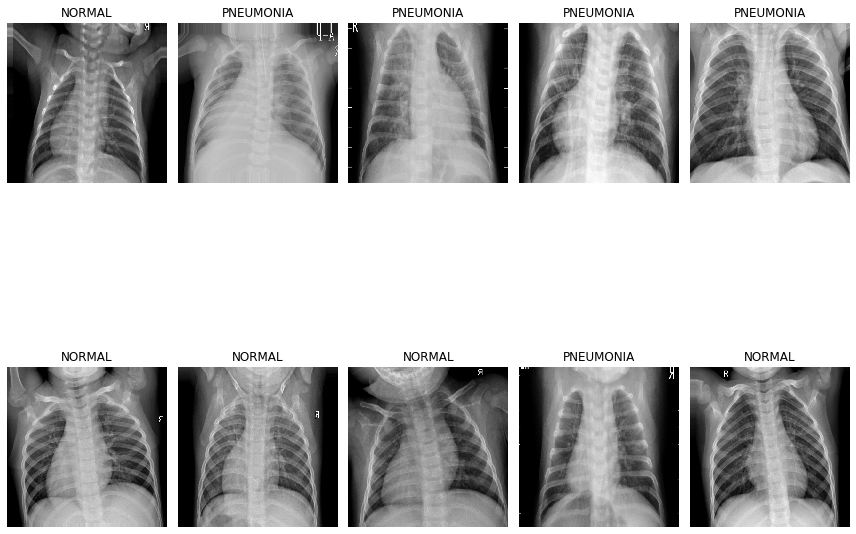

In [6]:
dic = {0:'NORMAL', 1:'PNEUMONIA'}
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]        
        
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

## BaseLine Model

In [7]:
cnn = models.Sequential([
                  layers.Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)),
                  layers.MaxPooling2D(pool_size = (2, 2)),

                  layers.Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)),
                  layers.MaxPooling2D(pool_size = (2, 2)),

                  layers.Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)),
                  layers.MaxPooling2D(pool_size = (2, 2)),

                  layers.Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)),
                  layers.MaxPooling2D(pool_size = (2, 2)),

                  layers.Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)),
                  layers.MaxPooling2D(pool_size = (2, 2)),

                  layers.Flatten(),
                  layers.Dense(activation = 'relu', units = 128),
                  layers.Dense(activation = 'relu', units = 64),
                  layers.Dense(activation = 'sigmoid', units = 1)     
])



cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 498, 498, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 249, 249, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 247, 247, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 123, 123, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 121, 121, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 58, 58, 64)        1

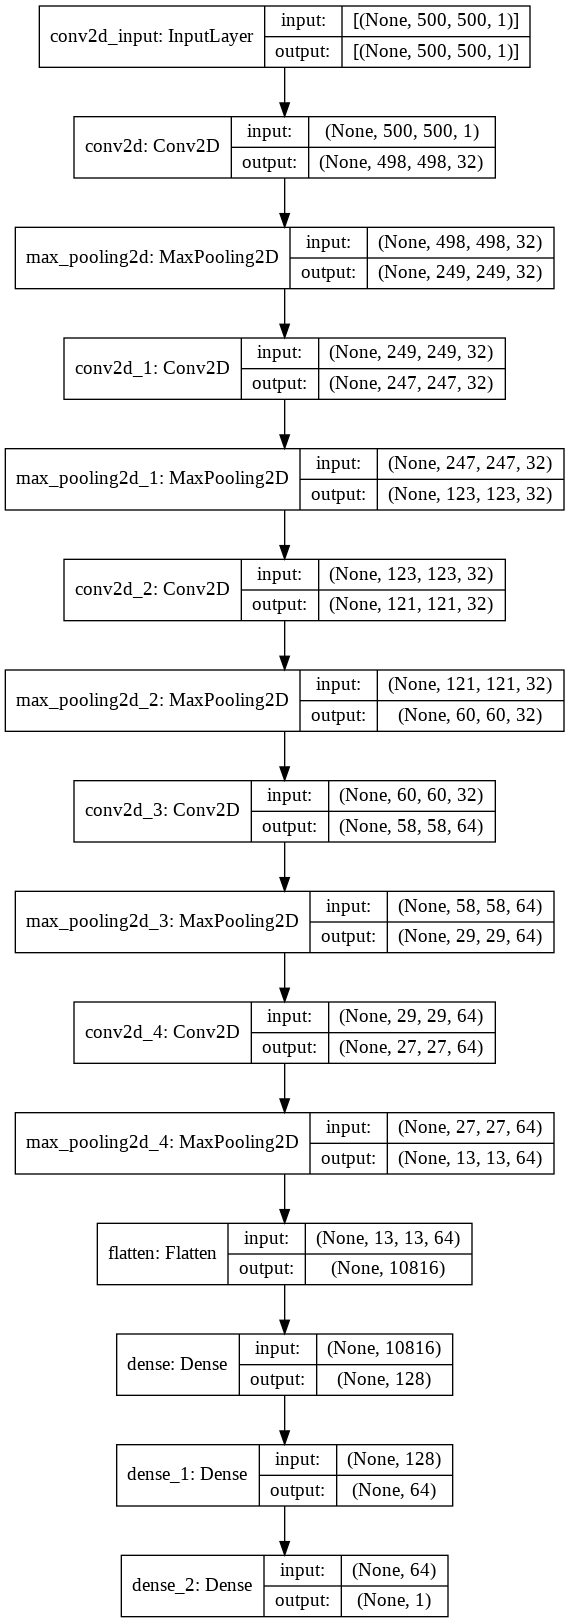

In [8]:
from tensorflow.keras.utils import plot_model
plot_model(cnn,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [9]:
early = EarlyStopping(monitor="val_loss", mode="min", patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor="val_loss", patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

In [10]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', np.unique(train.classes), train.classes)
cw = dict(zip( np.unique(train.classes), weights))
print(cw)

{0: 1.9448173005219984, 1: 0.6730322580645162}


In [11]:
cnn.fit(train,epochs=25, validation_data=valid, class_weight=cw, callbacks=callbacks_list)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/25
326/326 [==============================] - 163s 406ms/step - loss: 0.4561 - accuracy: 0.7540 - val_loss: 0.6088 - val_accuracy: 0.5625
Epoch 2/25
326/326 [==============================] - 134s 412ms/step - loss: 0.2821 - accuracy: 0.8850 - val_loss: 0.7120 - val_accuracy: 0.6250
Epoch 3/25
326/326 [==============================] - 133s 409ms/step - loss: 0.2236 - accuracy: 0.9130 - val_loss: 0.8077 - val_accuracy: 0.5625

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/25
326/326 [==============================] - 135s 413ms/step - loss: 0.1625 - accuracy: 0.9367 - val_loss: 0.5627 - val_accuracy: 0.6875
Epoch 5/25
326/326 [==============================] - 133s 409ms/step - loss: 0.1471 - accuracy: 0.9421 - val_loss: 0.8320 - val_accuracy: 0.6250
Epoch 6/25
326/326 [==============================]

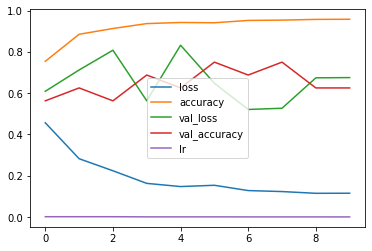

In [12]:
pd.DataFrame(cnn.history.history).plot()

In [13]:
raw_cnn_test_accu = cnn.evaluate(test)
print('The testing accuracy is :',raw_cnn_test_accu[1]*100, '%')

39/39 [==============================] - 5s 135ms/step - loss: 0.2614 - accuracy: 0.9167
The testing accuracy is : 91.66666865348816 %


## BaseLine model with dropout layers

In [14]:
cnn = models.Sequential([
          layers.Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)),
          layers.MaxPooling2D(pool_size = (2, 2)),

          layers.Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)),
          layers.MaxPooling2D(pool_size = (2, 2)),

          layers.Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)),
          layers.MaxPooling2D(pool_size = (2, 2)),
          
          layers.Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)),
          layers.MaxPooling2D(pool_size = (2, 2)),
          layers.Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)),
          layers.MaxPooling2D(pool_size = (2, 2)),
          layers.Dropout(0.2),
          layers.Flatten(),
          layers.Dense(activation = 'relu', units = 128),
          layers.Dropout(0.2),
          layers.Dense(activation = 'relu', units = 64),

          layers.Dense(activation = 'sigmoid', units = 1)      
])



cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 498, 498, 32)      320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 249, 249, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 247, 247, 32)      9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 123, 123, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 121, 121, 32)      9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 58, 58, 64)       

In [15]:
cnn.fit(train,epochs=25, validation_data=valid, class_weight=cw, callbacks=callbacks_list)

Epoch 1/25
326/326 [==============================] - 134s 408ms/step - loss: 0.4111 - accuracy: 0.7974 - val_loss: 0.5043 - val_accuracy: 0.8125
Epoch 2/25
326/326 [==============================] - 134s 410ms/step - loss: 0.2889 - accuracy: 0.8800 - val_loss: 0.5016 - val_accuracy: 0.7500
Epoch 3/25
326/326 [==============================] - 133s 407ms/step - loss: 0.2263 - accuracy: 0.9076 - val_loss: 0.6749 - val_accuracy: 0.7500
Epoch 4/25
326/326 [==============================] - 135s 412ms/step - loss: 0.2006 - accuracy: 0.9216 - val_loss: 0.4836 - val_accuracy: 0.8125
Epoch 5/25
326/326 [==============================] - 133s 408ms/step - loss: 0.1852 - accuracy: 0.9266 - val_loss: 0.6201 - val_accuracy: 0.6875
Epoch 6/25
326/326 [==============================] - 134s 412ms/step - loss: 0.1701 - accuracy: 0.9339 - val_loss: 1.0341 - val_accuracy: 0.6875

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 7/25
326/326 [=======================

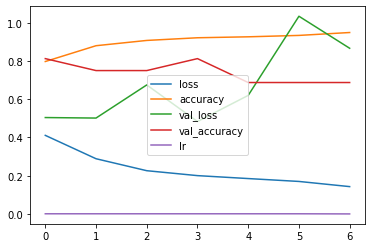

In [16]:
pd.DataFrame(cnn.history.history).plot()

In [17]:
raw_cnn_dropout_test_accu = cnn.evaluate(test)
print('The testing accuracy is :',raw_cnn_dropout_test_accu[1]*100, '%')

39/39 [==============================] - 6s 146ms/step - loss: 0.3163 - accuracy: 0.8974
The testing accuracy is : 89.74359035491943 %


## Transfer Learning

Source : https://keras.io/api/applications/#usage-examples-for-image-classification-models

### mobileNet_v2 model

In [18]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [19]:
model = models.Sequential([
                           pretrained_model_without_top_layer,
                           layers.Dense(1, activation='softmax')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [20]:
train_set = image_gen.flow_from_directory(
      train_path,
      target_size=(224, 224),
      class_mode='binary',
      batch_size=32
      )
test_set = test_data_gen.flow_from_directory(
      test_path,
      target_size=(224, 224),
      shuffle=False,
      class_mode='binary',
      batch_size=32
      )
valid_set = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(224, 224),
      class_mode='binary', 
      batch_size=32
      )

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [21]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

model.fit(train_set,epochs=25, validation_data=valid_set, class_weight=cw, callbacks=callbacks_list)

Epoch 1/25
163/163 [==============================] - 100s 597ms/step - loss: 0.2584 - accuracy: 0.7429 - val_loss: 0.2975 - val_accuracy: 0.5000
Epoch 2/25
163/163 [==============================] - 98s 600ms/step - loss: 0.1453 - accuracy: 0.7429 - val_loss: 0.4372 - val_accuracy: 0.5000
Epoch 3/25
163/163 [==============================] - 98s 599ms/step - loss: 0.1278 - accuracy: 0.7429 - val_loss: 0.3439 - val_accuracy: 0.5000

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/25
163/163 [==============================] - 99s 605ms/step - loss: 0.1206 - accuracy: 0.7429 - val_loss: 0.2897 - val_accuracy: 0.5000
Epoch 5/25
163/163 [==============================] - 97s 594ms/step - loss: 0.1129 - accuracy: 0.7429 - val_loss: 0.2720 - val_accuracy: 0.5000
Epoch 6/25
163/163 [==============================] - 96s 592ms/step - loss: 0.1080 - accuracy: 0.7429 - val_loss: 0.2395 - val_accuracy: 0.5000
Epoch 7/25
163/163 [============================

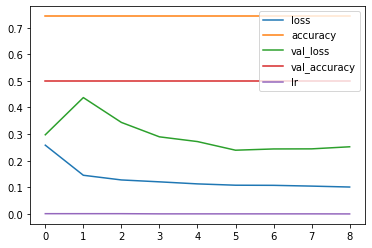

In [22]:
pd.DataFrame(model.history.history).plot()

In [23]:
mobile_v2_test_accu = model.evaluate(test_set)
print('The testing accuracy is :',mobile_v2_test_accu[1]*100, '%')

20/20 [==============================] - 5s 253ms/step - loss: 0.2868 - accuracy: 0.6250
The testing accuracy is : 62.5 %


Epoch 1/25
163/163 [==============================] - 99s 604ms/step - loss: 0.1659 - accuracy: 0.9346 - val_loss: 0.2369 - val_accuracy: 0.8750
Epoch 2/25
163/163 [==============================] - 97s 593ms/step - loss: 0.1149 - accuracy: 0.9540 - val_loss: 0.1765 - val_accuracy: 0.8750
Epoch 3/25
163/163 [==============================] - 98s 603ms/step - loss: 0.0983 - accuracy: 0.9595 - val_loss: 0.2127 - val_accuracy: 0.8750
Epoch 4/25
163/163 [==============================] - 98s 599ms/step - loss: 0.0875 - accuracy: 0.9655 - val_loss: 0.3229 - val_accuracy: 0.8125

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 5/25
163/163 [==============================] - 96s 590ms/step - loss: 0.0828 - accuracy: 0.9670 - val_loss: 0.1242 - val_accuracy: 0.9375
Epoch 6/25
163/163 [==============================] - 97s 595ms/step - loss: 0.0798 - accuracy: 0.9688 - val_loss: 0.1269 - val_accuracy: 0.9375
Epoch 7/25
163/163 [=============================

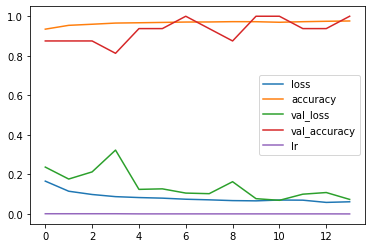

In [24]:
model = models.Sequential([
                           pretrained_model_without_top_layer,
                           layers.Dense(activation = 'relu', units = 128),
                            layers.Dense(activation = 'relu', units = 64),

                            layers.Dense(activation = 'sigmoid', units = 1)     
])

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

model.fit(train_set,epochs=25, validation_data=valid_set, class_weight=cw, callbacks=callbacks_list)

pd.DataFrame(model.history.history).plot()

In [25]:
mobile_v2_dense_test_accu = model.evaluate(test_set)
print('The testing accuracy is :',mobile_v2_dense_test_accu[1]*100, '%')

20/20 [==============================] - 6s 254ms/step - loss: 0.3220 - accuracy: 0.8926
The testing accuracy is : 89.26281929016113 %


### InceptionV3 model

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(1024, activation='relu')(x)

predictions = layers.Dense(1, activation='softmax')(x)

model = models.Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

model.fit(train_set,epochs=25, validation_data=valid_set, class_weight=cw, callbacks=callbacks_list)

87916544/87910968 [==============================] - 1s 0us/step
Epoch 1/25
163/163 [==============================] - 107s 632ms/step - loss: 0.3449 - accuracy: 0.7429 - val_loss: 0.4560 - val_accuracy: 0.5000
Epoch 2/25
163/163 [==============================] - 100s 612ms/step - loss: 0.2066 - accuracy: 0.7429 - val_loss: 0.4373 - val_accuracy: 0.5000
Epoch 3/25
163/163 [==============================] - 99s 606ms/step - loss: 0.1900 - accuracy: 0.7429 - val_loss: 0.5407 - val_accuracy: 0.5000
Epoch 4/25
163/163 [==============================] - 101s 616ms/step - loss: 0.1726 - accuracy: 0.7429 - val_loss: 0.5559 - val_accuracy: 0.5000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 5/25
163/163 [==============================] - 100s 614ms/step - loss: 0.1471 - accuracy: 0.7429 - val_loss: 0.3641 - val_accuracy: 0.5000
Epoch 6/25
163/163 [==============================] - 100s 617ms/step - loss: 0.1506 - accuracy: 0.7429 - val_loss: 0.3783 - 

In [ ]:
pd.DataFrame(model.history.history).plot()

In [ ]:
inception_v3_test_accu = model.evaluate(test_set)
print('The testing accuracy is :',inception_v3_test_accu[1]*100, '%')

### VGG16

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(weights='imagenet', include_top=False)

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
predictions = layers.Dense(1, activation='softmax')(x)

model = models.Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

model.fit(train_set,epochs=25, validation_data=valid_set)


In [ ]:
pd.DataFrame(model.history.history).plot()

In [ ]:
vgg16_test_accu = model.evaluate(test_set)
print('The testing accuracy is :',vgg16_test_accu[1]*100, '%')

### ResNet50

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False)

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(1024, activation='relu')(x)

predictions = layers.Dense(1, activation='softmax')(x)

model = models.Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

model.fit(train_set,epochs=25, validation_data=valid_set, class_weight=cw, callbacks=callbacks_list)

pd.DataFrame(model.history.history).plot()

In [ ]:
resnet50_test_accu = model.evaluate(test_set)
print('The testing accuracy is :',resnet50_test_accu[1]*100, '%')

# Summary

In [ ]:
from tabulate import tabulate

mydata = [{"Raw CNN", raw_cnn_test_accu}, 
          {"Raw CNN with Dropout", raw_cnn_dropout_test_accu}, 
          {"Mobile_v2", mobile_v2_test_accu}, 
          {"Mobile_v2 with Dense", mobile_v2_dense_test_accu}, 
          {"Inception_v3", inception_v3_test_accu}, 
          {"VGG16", vgg16_test_accu}, 
          {"resnet50", resnet50_test_accu}, ]

head = ["Model", "Test Accuracy"]

print(tabulate(mydata, headers=head, tablefmt="grid"))